In [15]:
import pandas as pd 
import numpy as np 
import os
import pandas as pd

desktop_path = os.path.join(os.path.expanduser("~"), "Desktop", "datafix.csv")
datafix = pd.read_csv(desktop_path)


In [16]:
datafix = datafix.set_index("Date")

In [17]:
datafix

,Open,High,Low,Close,Volume,Kalman,Kalman_Roc,MACD,Signal,MACD_Hist,days_to_expiry,stock price,strike,rfr,type,IV,IVROC
Date,,,,,,,,,,,,,,,,,
2025-06-10 10:00:00,11.49,11.80,11.35,11.55,69.0,11.550000,NaN,0.000000,0.000000,0.000000,10.0,315.83,320,0.0429,p,0.454486,NaN
2025-06-10 10:01:00,11.60,12.40,11.60,12.25,120.0,12.191522,5.554306,0.055840,0.011168,0.044672,10.0,316.65,320,0.0429,p,0.509360,12.073698
2025-06-10 10:02:00,12.30,12.65,12.27,12.44,121.0,12.502266,2.548853,0.114110,0.031757,0.082354,10.0,317.18,320,0.0429,p,0.531701,4.386121
2025-06-10 10:03:00,12.30,12.60,12.25,12.40,118.0,12.558558,0.450251,0.155272,0.056460,0.098813,10.0,317.15,320,0.0429,p,0.529047,-0.499130
2025-06-10 10:04:00,12.40,12.40,11.95,12.05,267.0,12.354756,-1.622816,0.157832,0.076734,0.081098,10.0,316.46,320,0.0429,p,0.494937,-6.447468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-13 15:55:00,13.25,13.64,13.05,13.44,82.0,13.345323,-0.228850,-0.351478,-0.299315,-0.052163,7.0,325.07,320,0.0429,p,0.896905,-0.664812
2025-06-13 15:56:00,13.50,13.79,13.50,13.74,14.0,13.404025,0.439872,-0.321475,-0.303747,-0.017728,7.0,325.58,320,0.0429,p,0.926111,3.256369
2025-06-13 15:57:00,13.67,13.75,13.65,13.66,21.0,13.432462,0.212148,-0.300687,-0.303135,0.002448,7.0,325.53,320,0.0429,p,0.920380,-0.618850


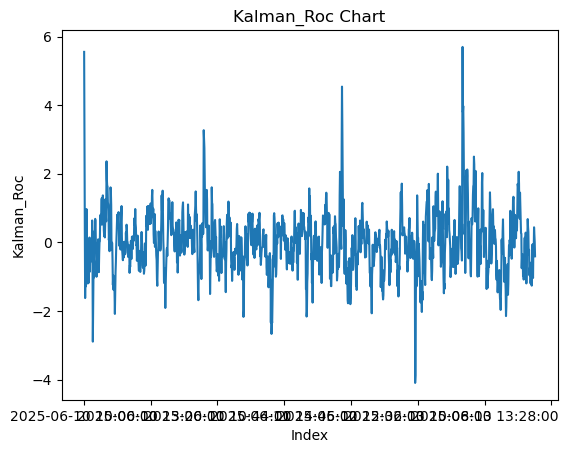

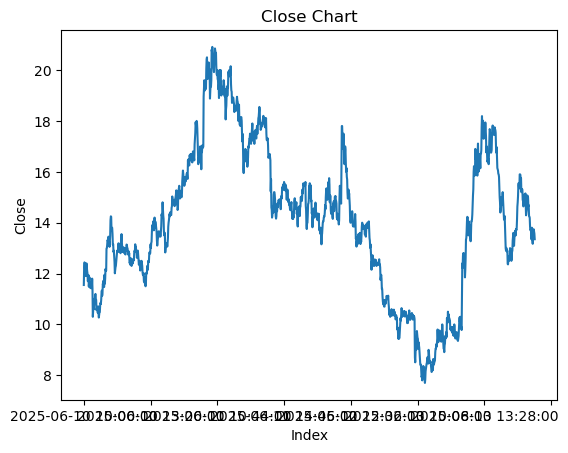

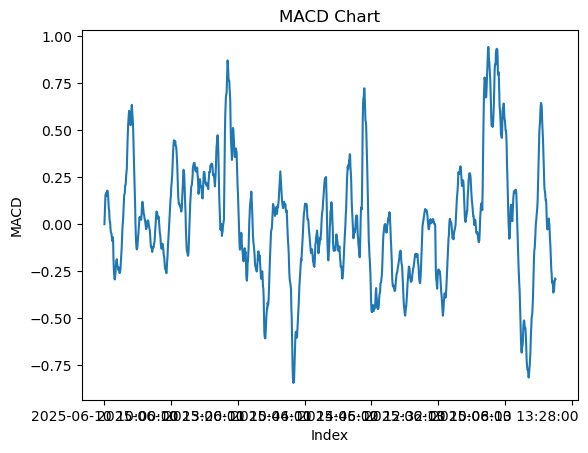

In [18]:
import matplotlib.pyplot as plt
def plot(name):
    column_to_plot = name  # Replace with your actual column name

    if column_to_plot in datafix.columns:
     datafix[column_to_plot].plot(kind='line', title=f"{column_to_plot} Chart")
     plt.xlabel("Index")
     plt.ylabel(column_to_plot)
     plt.show()
    else:
        print(f"Column '{column_to_plot}' not found in datafix DataFrame.")
plot("Kalman_Roc")
plot("Close")
plot("MACD")

In [36]:
import numpy as np

buy_condition = (datafix["MACD_Hist"] > 0.10) & (datafix["Kalman_Roc"] > 0.1 ) & (datafix["Volume"].rolling(3).mean() > 60)

datafix["Signal"] = None
datafix["max_gain"] = np.nan

in_position = False
current_max = np.nan
signals = [None] * len(datafix)

for int_idx, (df_idx, row) in enumerate(datafix.iterrows()):
    if not in_position:
        if buy_condition.loc[df_idx]:
            signals[int_idx] = "buy"
            in_position = True
            current_max = row["Close"]
            datafix.at[df_idx, "max_gain"] = current_max
    else:
        current_max = max(current_max, row["Close"])
        datafix.at[df_idx, "max_gain"] = current_max
        if row["Close"] < current_max * 0.80:
            signals[int_idx] = "sell"
            in_position = False
            current_max = np.nan

datafix["Signal"] = signals
datafix["AvgVol"] = datafix["Volume"].rolling(20).mean()


In [37]:
datafix.tail(10)

,Open,High,Low,Close,Volume,Kalman,Kalman_Roc,MACD,Signal,MACD_Hist,days_to_expiry,stock price,strike,rfr,type,IV,IVROC,max_gain,AvgVol
Date,,,,,,,,,,,,,,,,,,,
2025-06-13 15:50:00,13.68,13.95,13.67,13.80,273.0,13.659495,-0.114425,-0.308265,None,-0.103440,7.0,325.58,320,0.0429,p,0.929518,4.822847,15.9,64.30
2025-06-13 15:51:00,13.94,13.94,13.74,13.80,53.0,13.650683,-0.064515,-0.302239,None,-0.077931,7.0,325.64,320,0.0429,p,0.930943,0.153383,15.9,65.05
2025-06-13 15:52:00,13.84,13.84,13.30,13.33,85.0,13.522678,-0.937717,-0.331567,None,-0.085807,7.0,325.03,320,0.0429,p,0.889702,-4.430065,15.9,68.75
2025-06-13 15:53:00,13.44,13.45,13.17,13.17,39.0,13.382511,-1.036533,-0.363529,None,-0.094215,7.0,324.61,320,0.0429,p,0.870506,-2.157594,15.9,68.25
2025-06-13 15:54:00,13.22,13.55,13.22,13.55,20.0,13.375934,-0.049148,-0.354114,None,-0.067841,7.0,325.06,320,0.0429,p,0.902907,3.722125,15.9,68.80
2025-06-13 15:55:00,13.25,13.64,13.05,13.44,82.0,13.345323,-0.228850,-0.351478,None,-0.052163,7.0,325.07,320,0.0429,p,0.896905,-0.664812,15.9,66.10
2025-06-13 15:56:00,13.50,13.79,13.50,13.74,14.0,13.404025,0.439872,-0.321475,None,-0.017728,7.0,325.58,320,0.0429,p,0.926111,3.256369,15.9,65.80
2025-06-13 15:57:00,13.67,13.75,13.65,13.66,21.0,13.432462,0.212148,-0.300687,None,0.002448,7.0,325.53,320,0.0429,p,0.920380,-0.618850,15.9,65.20
2025-06-13 15:58:00,13.70,13.70,13.57,13.57,52.0,13.433916,0.010829,-0.288153,None,0.011986,7.0,325.48,320,0.0429,p,0.914080,-0.684486,15.9,66.80


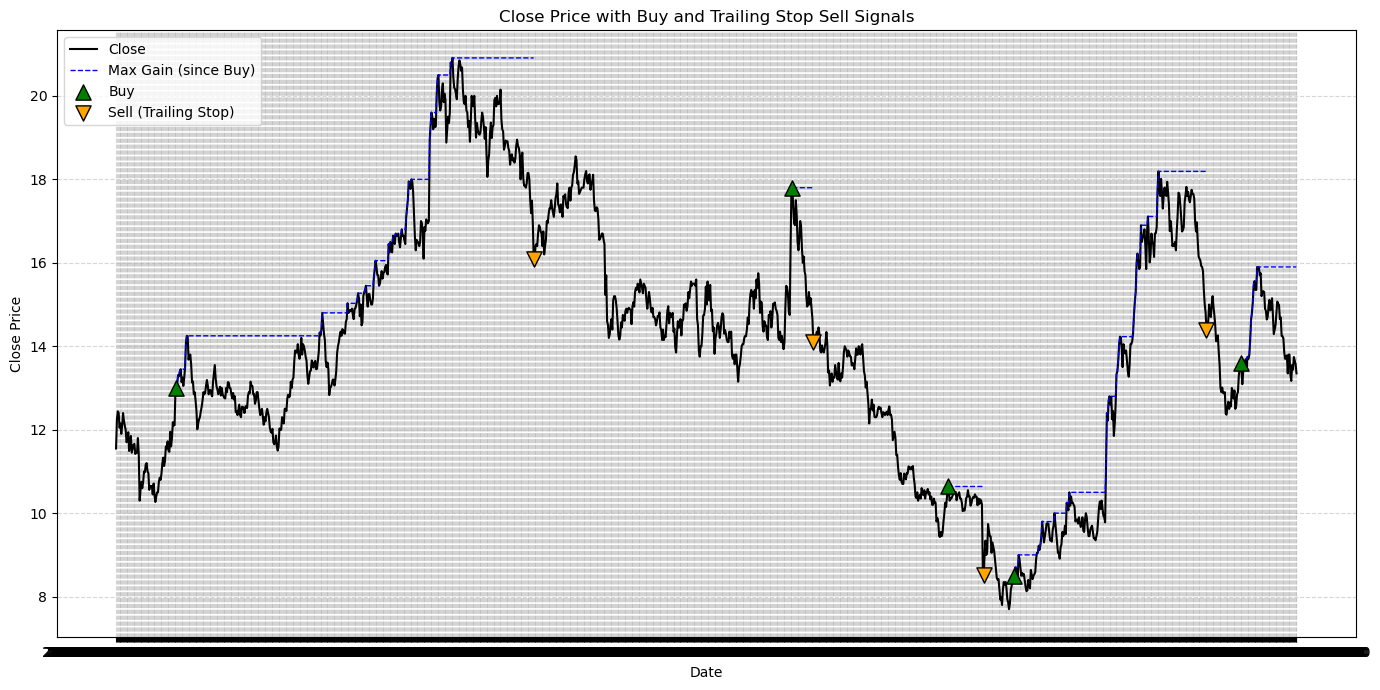

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

# Plot the Close price
plt.plot(datafix.index, datafix["Close"], label="Close", color="black", linewidth=1.5)

# (Optional) Plot the running max_gain as a blue dashed line
plt.plot(datafix.index, datafix["max_gain"], label="Max Gain (since Buy)", color="blue", linestyle="dashed", linewidth=1)

# Plot buy signals (green upward triangle)
buy_signals = datafix[datafix["Signal"] == "buy"]
plt.scatter(buy_signals.index, buy_signals["Close"], marker="^", color="green", edgecolor="black", s=120, label="Buy", zorder=3)

# Plot sell signals (orange downward triangle)
sell_signals = datafix[datafix["Signal"] == "sell"]
plt.scatter(sell_signals.index, sell_signals["Close"], marker="v", color="orange", edgecolor="black", s=120, label="Sell (Trailing Stop)", zorder=3)

plt.title("Close Price with Buy and Trailing Stop Sell Signals")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend(loc="upper left")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()



plt.show()
